# Test EEG-DBS Synchronisation of EPI Data

In [1]:
import numpy as np
import pandas as pd
import sys

sys.path.append(r"C:\Users\slena\Repos\ngb_study\EEG\Python")
from pathlib import Path
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, iirnotch, spectrogram, welch
import json
# EEG packages
import mne
# print current working directory
import os
print(os.getcwd())

# go one step back in the directory
os.chdir("..")
print(os.getcwd())

def load_json_file(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data


/Users/lenasalzmann/dev/dbs-eeg-sync/notebooks
/Users/lenasalzmann/dev/dbs-eeg-sync


In [2]:
from source import data_loader
from source.power_calculater import  compute_samplewise_eeg_power

In [3]:
# load eeg data
file_path = "/Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/eeg_epi_pat1_raw.fif"
eeg_raw = mne.io.read_raw_fif(file_path, preload=True)

print(eeg_raw)

Opening raw data file /Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/eeg_epi_pat1_raw.fif...
Isotrak not found
    Range : 0 ... 406327 =      0.000 ...  1587.215 secs
Ready.
Reading 0 ... 406327  =      0.000 ...  1587.215 secs...
<Raw | eeg_epi_pat1_raw.fif, 41 x 406328 (1587.2 s), ~127.1 MiB, data loaded>


In [4]:
eeg_raw.info['sfreq']
#length of the eeg recording in seconds
eeg_raw.n_times / eeg_raw.info['sfreq']


np.float64(1587.21875)

In [5]:
# read json file: /Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/Report_Json_Session_Report_20250714T125042_anonym.json
json_file = Path(r"/Volumes/green_groups_re_public/RELab/Data_confidential/StimuLOOP_Neurofeedback/eeg_dbs_sync_epi/Report_Json_Session_Report_20250714T125042_anonym.json")
json_data = data_loader.open_json_file(json_file)

In [6]:
for i in range(len(json_data["BrainSenseLfp"])):
    print(i, '   ' , len(json_data["BrainSenseLfp"][i]["LfpData"])/2, '   ' , len(json_data["BrainSenseLfp"][i]["LfpData"])/2/60
          )

0     85.0     1.4166666666666667


In [7]:
# get time domain data from json file
recording_number = 0
time_domain_data = data_loader.read_time_domain_data(json_data, 0)

---
Successfully read DBS recording 0 with sampling frequency 250 Hz
...length of dbs signal in seconds: 85.248
...length of dbs signal in samples: 21312


Compute EEG power

In [8]:
eeg_raw.info['sfreq']

256.0

In [9]:
round(eeg_raw.n_times / eeg_raw.info['sfreq']) 

1587

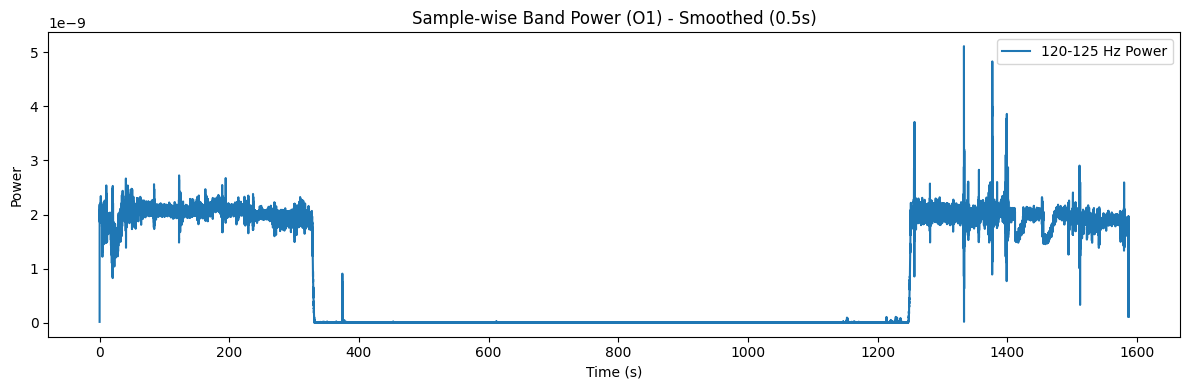

In [10]:
eeg_power, time_axis = compute_samplewise_eeg_power(eeg_raw, 120, 125, channel='O1', plot=True)


In [11]:
# add 2 synchronisation events to eeg data
sync1_sec = 1408.7461
sync2_sec = 1453.668

# Define sync event onsets and descriptions
onsets = [sync1_sec, sync2_sec]  # in seconds
durations = [0, 0]  # 0 duration = point event
descriptions = ['sync1', 'sync2']

# Create and add annotations
annotations = mne.Annotations(onset=onsets, duration=durations, description=descriptions)
eeg_raw.set_annotations(annotations)


<Raw | eeg_epi_pat1_raw.fif, 41 x 406328 (1587.2 s), ~127.1 MiB, data loaded>

Used Annotations descriptions: [np.str_('sync1'), np.str_('sync2')]
Not setting metadata
2 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 2 events and 513 original time points ...
0 bad epochs dropped
Using matplotlib as 2D backend.


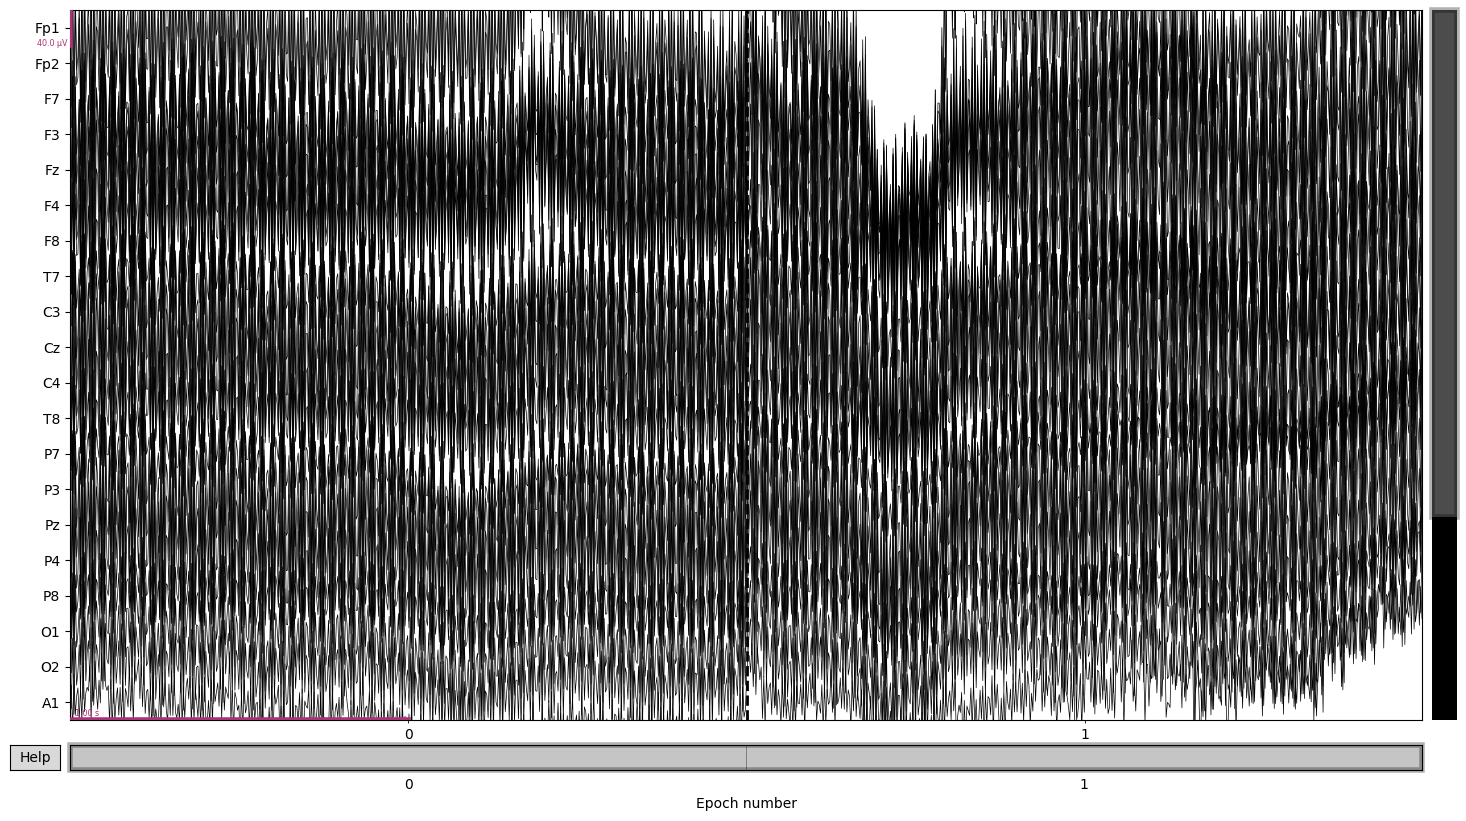

In [12]:
# Convert annotations to events
events, event_id = mne.events_from_annotations(eeg_raw)

# Define epochs around each event
tmin = -1.0  # 1 sec before event
tmax = 1.0   # 2 sec after event

epochs = mne.Epochs(eeg_raw, events=events, event_id=event_id,
                    tmin=tmin, tmax=tmax, baseline=(None, 0), preload=True)

# Plot the epochs
epochs.plot();

Plotting epoch for: sync1


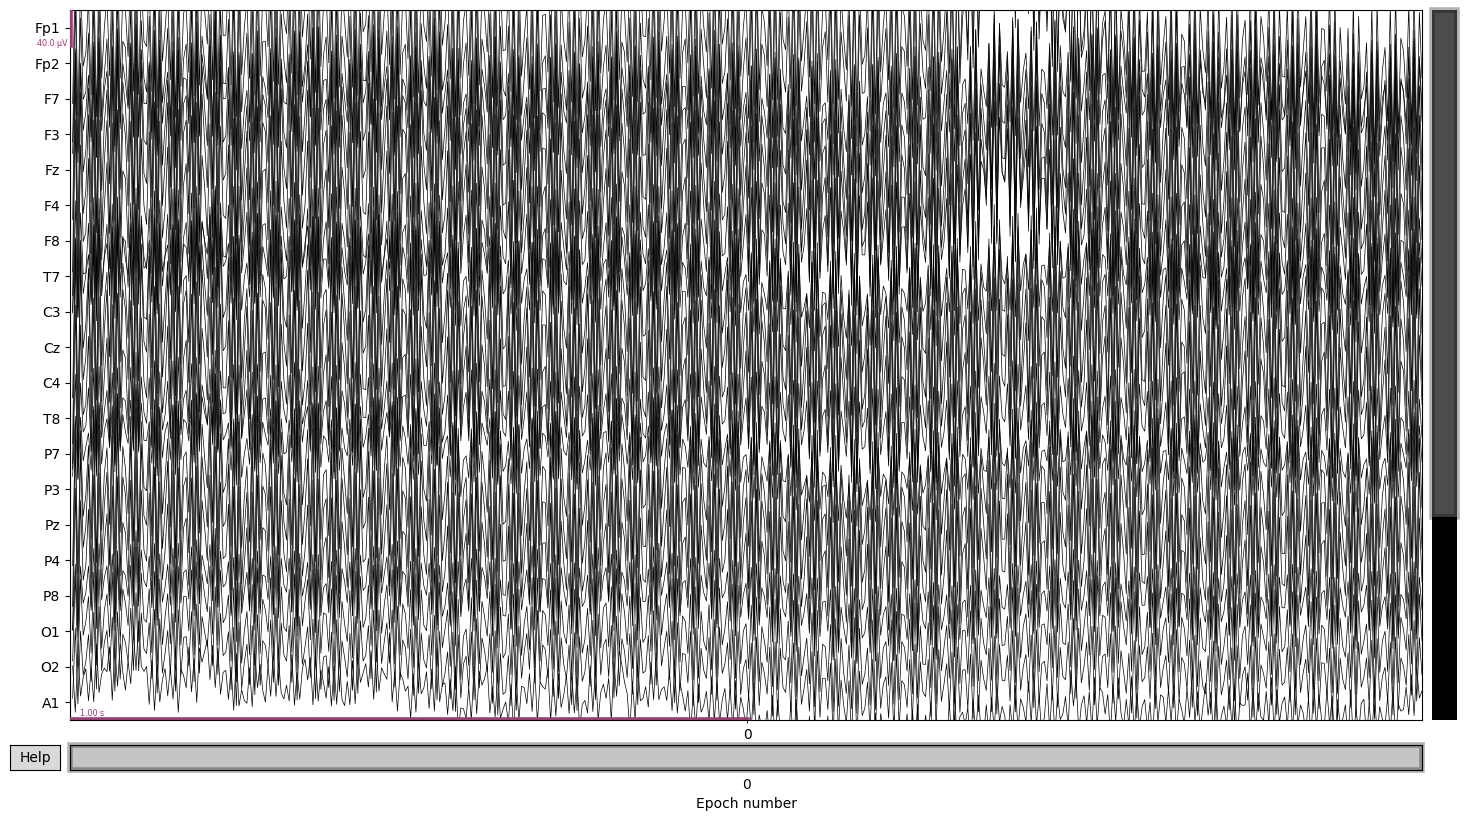

Plotting epoch for: sync2


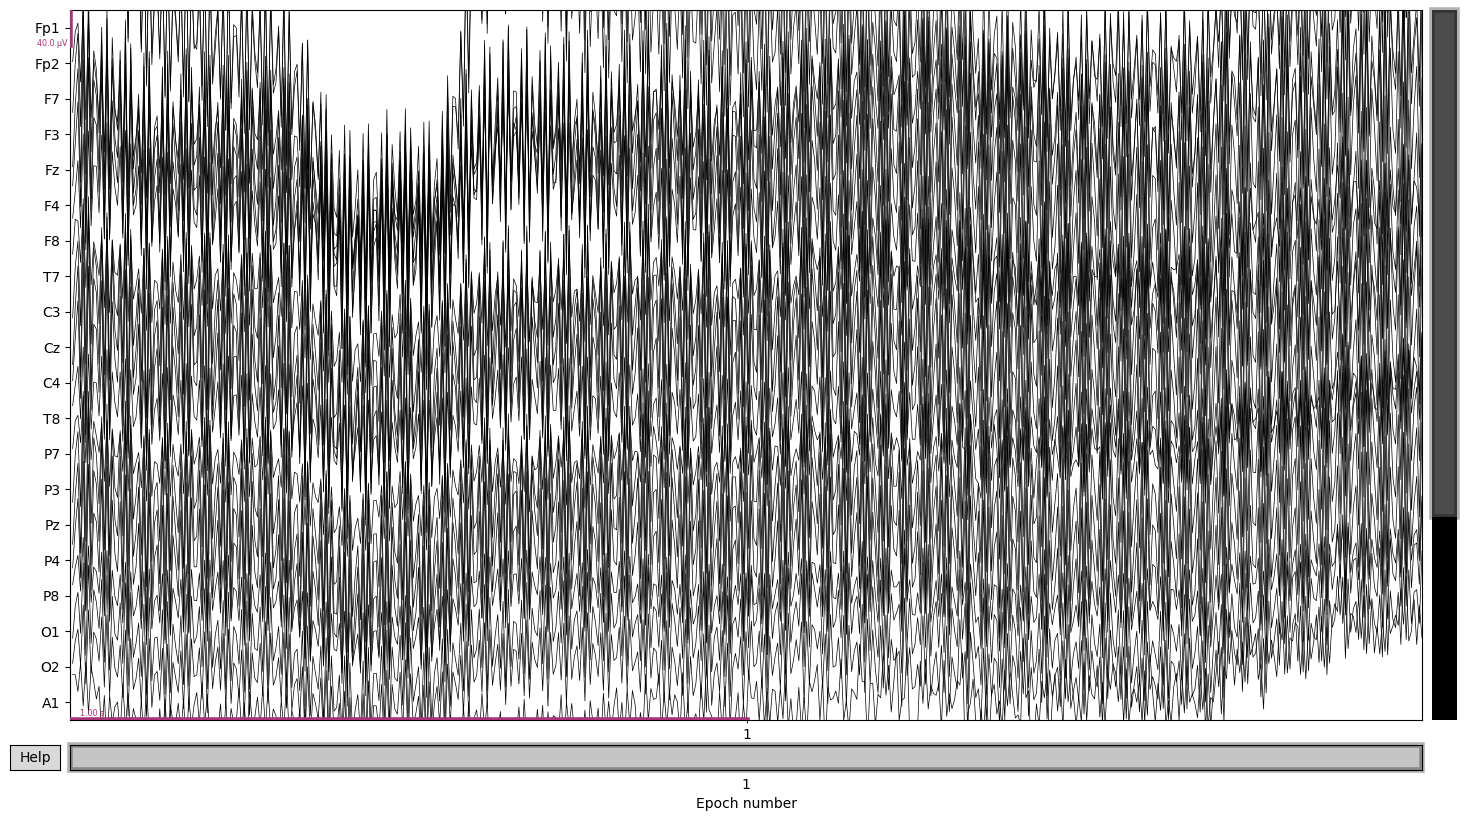

In [13]:
event_names = list(event_id.keys())  # ['sync1', 'sync2']
for name in event_names:
    print(f"Plotting epoch for: {name}")
    epoch = epochs[name]  # returns an Epochs object for this event
    epoch.plot(n_epochs=1, title=f"EEG around {name}");

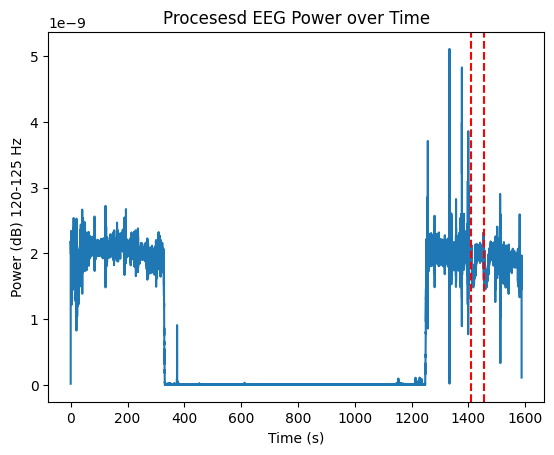

In [14]:
# plot eeg_power over time_axis between 1350 and 1500 s
plt.plot(time_axis, eeg_power)
# x-axis label
plt.xlabel('Time (s)')
# y-axis label
plt.ylabel('Power (dB) 120-125 Hz')
# title
plt.title('Procesesd EEG Power over Time')
# add vertical lines at sync1 and sync2
plt.axvline(x=sync1_sec, color='r', linestyle='--')
plt.axvline(x=sync2_sec, color='r', linestyle='--')
plt.show()


Crop the data around the artifacts

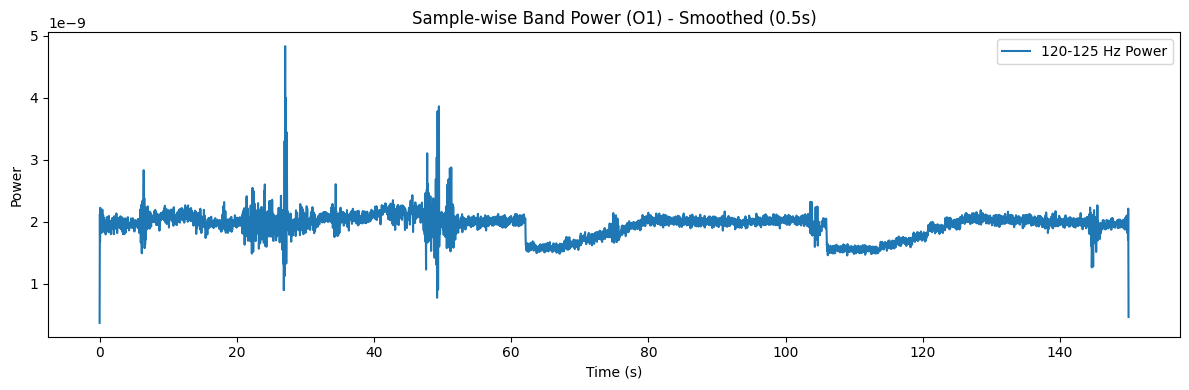

In [16]:
# cut eeg data between 1350 and 1500 s
eeg_raw_cut = eeg_raw.copy().crop(1350, 1500)

# compute eeg power between 1350 and 1500 s
eeg_power_cut, time_axis_cut = compute_samplewise_eeg_power(eeg_raw_cut, 120, 125, channel='O1', plot=True)

Zoom in and plot

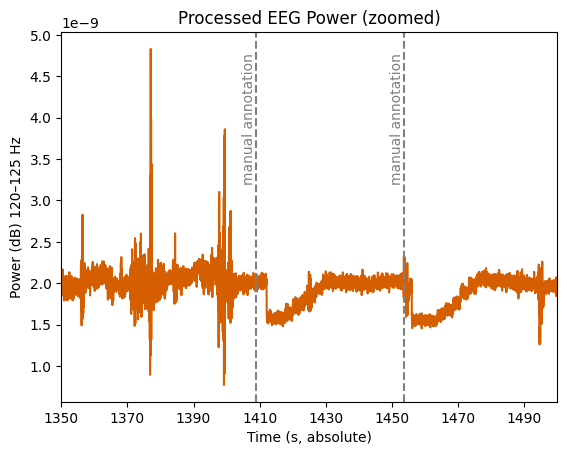

In [26]:
from matplotlib.ticker import FuncFormatter

# given
sync1_sec = 1408.7461
sync2_sec = 1453.668
t = time_axis            # long absolute time vector
p = eeg_power               # same length

t0, t1 = 1350.0, 1500.0
offset = t0
m = (t >= t0) & (t <= t1)

fig, ax = plt.subplots()
ax.plot(t[m] - offset, p[m], color='#D55E00')

for s in (sync1_sec, sync2_sec):
    ax.axvline(s - offset, color='grey', ls='--')
    ax.text(s - offset, ax.get_ylim()[1]*0.95, "manual annotation",
            color="grey", rotation=90, va="top", ha="right")

ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x + offset:.0f}"))
ax.set_xlim(0, t1 - t0)
ax.set_xlabel("Time (s, absolute)")
ax.set_ylabel("Power (dB) 120–125 Hz")
ax.set_title("Processed EEG Power (zoomed)")

plt.savefig(f"notebooks/outputs/plots/fig3_validation_manual_sync.pdf")

plt.show()